# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
from tensorflow.compat.v1 import InteractiveSession # This is needed to run on Windows 10 laptop with Cuda

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# This is needed to run on Windows 10 laptop with Cuda
print(tf.__version__)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2.1.0


![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
# Task:
# Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
import numpy as np
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(32, 32, 3, 73257)
(73257, 1)
(32, 32, 3, 26032)
(26032, 1)


In [5]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder().fit(y_train)
y_train = enc.transform(y_train).toarray()
y_test = enc.transform(y_test).toarray()

In [6]:
print(y_train.shape)
print(y_train[0])

(73257, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
# Task:
# Convert the training and test images to grayscale by taking the average across all colour channels 
# for each pixel. Hint: retain the channel dimension, which will now have size 1

In [8]:
X_train_avg = np.swapaxes(X_train, 3,0)
print(X_train_avg.shape)
X_train_avg = np.swapaxes(X_train_avg, 3,2)
X_train_avg = np.swapaxes(X_train_avg, 1,2)
print(X_train_avg.shape)

(73257, 32, 3, 32)
(73257, 32, 32, 3)


In [9]:
X_train_avg = np.mean(X_train_avg,axis=3)
X_train_avg =X_train_avg[..., np.newaxis]
print(X_train_avg.shape)
print(X_train_avg[1].shape)

(73257, 32, 32, 1)
(32, 32, 1)


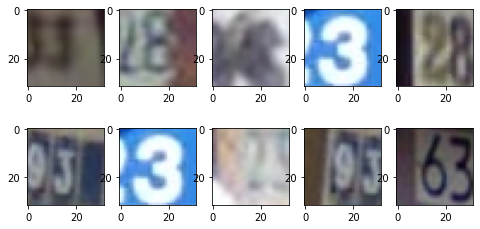

In [10]:
# Task:
# Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
import numpy as np
import matplotlib.pyplot as plt
import random

w=10
h=2
fig=plt.figure(figsize=(8,4))
columns = 5
rows = 2
shp=(X_train.shape)[0]
#print(random.randint(0,shp))
for i in range(1, columns*rows+1):
    indx = random.randint(0,shp)
    img = X_train[...,indx]
    fig.add_subplot(rows,columns, i)
    plt.imshow(img)
plt.show()

(32, 32)


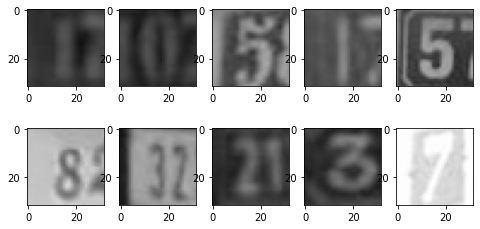

In [11]:
# Task:
# Select a random sample of the grayscale images and corresponding labels 
# from the dataset (at least 10), and display them in a figure.

print(X_train_avg[1].squeeze(axis=2).shape)
w=10
h=2
fig=plt.figure(figsize=(8,4))
columns = 5
rows = 2
shp=(X_train_avg.shape)[0]
#print(random.randint(0,shp))
for i in range(1, columns*rows+1):
    indx = random.randint(0,shp)
    img = X_train_avg[indx].squeeze(axis=2)
    fig.add_subplot(rows,columns, i)
    plt.imshow(img,cmap='gray',vmin=0,vmax=255,label=y_train[indx])
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [12]:
def get_seq_model(input_shape):
    model = Sequential([
                    Dense(128, input_shape=input_shape, activation='relu'),
                    Flatten(),
                    Dense(64, activation='relu'),
                    BatchNormalization(),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    Dense(10, activation='softmax'),
                        ])
    return model
    

In [13]:
def compile_seq_model(model):

    model.compile(optimizer='adam',
                 loss = ['categorical_crossentropy'],
                 metrics=['acc'])

In [14]:
checkpoint = ModelCheckpoint(filepath = 'SeqModel\mySeqModel', save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=1)
earlystop = EarlyStopping(patience=5, monitor='loss')

In [15]:
def train_seq_model(model, scaled_train_images, train_labels, epochs):
    
    history = model.fit(scaled_train_images, train_labels, 
                        epochs=epochs,batch_size=40,validation_split=0.15,verbose=1,
                        callbacks=[checkpoint, earlystop])
    return history

In [15]:
print(X_train_avg[0].shape)
print(y_train[0])
model = get_seq_model(X_train_avg[0].shape)
compile_seq_model(model)
model.summary()

(32, 32, 1)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 32, 128)       256       
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8388672   
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dro

In [17]:
history = train_seq_model(model,X_train_avg,y_train,30)

(32, 32, 1)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62200/62268 [============================>.] - ETA: 0s - loss: 1.7648 - acc: 0.3899
Epoch 00001: val_loss improved from inf to 1.52954, saving model to SeqModel\mySeqModel
62268/62268 [==============================] - 48s 768us/sample - loss: 1.7644 - acc: 0.3900 - val_loss: 1.5295 - val_acc: 0.4964
Epoch 2/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.3678 - acc: 0.5580
Epoch 00002: val_loss improved from 1.52954 to 1.25956, saving model to SeqModel\mySeqModel
62268/62268 [==============================] - 46s 731us/sample - loss: 1.3677 - acc: 0.5580 - val_loss: 1.2596 - val_acc: 0.5786
Epoch 3/30
62200/62268 [============================>.] - ETA: 0s - loss: 1.2472 - acc: 0.6059
Epoch 00003: val_loss did not improve from 1.25956
62268/62268 [==============================] - 45s 724us/sample - loss: 1.2471 - acc: 0.6059 - val_loss: 1.2976 - val_acc: 0.5563


62268/62268 [==============================] - 48s 763us/sample - loss: 0.9097 - acc: 0.7224 - val_loss: 0.9346 - val_acc: 0.7145
Epoch 30/30
62200/62268 [============================>.] - ETA: 0s - loss: 0.9115 - acc: 0.7209
Epoch 00030: val_loss improved from 0.93458 to 0.89641, saving model to SeqModel\mySeqModel
62268/62268 [==============================] - 47s 761us/sample - loss: 0.9115 - acc: 0.7208 - val_loss: 0.8964 - val_acc: 0.7180


In [18]:
model.save('seqmodel\\seqmodel.h5')

Text(0.5, 1.0, 'Loss')

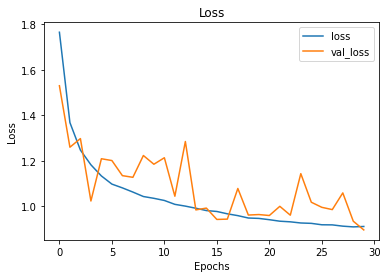

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

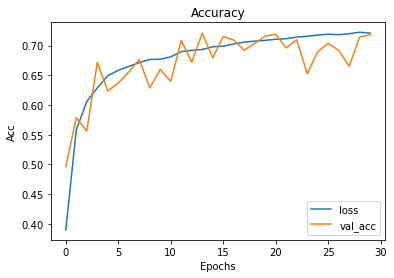

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['loss','val_acc'], loc='lower right')
plt.title("Accuracy")

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [23]:
def get_conv_model(input_shape):
    model = Sequential([
        Conv2D(filters= 16, kernel_size= 3, activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size= (3,3), strides=1),
        Conv2D(filters= 32, kernel_size = 3, padding='valid', strides=1, activation='relu'),
        MaxPooling2D(pool_size = (1,1), strides = 3),
        BatchNormalization(),
        Conv2D(filters= 32, kernel_size = 3, padding='valid', strides=2, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    return model

In [24]:
def compile_conv_model(model):

    model.compile(optimizer='adam',
                 loss = ['categorical_crossentropy'],
                 metrics=['accuracy'])

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 7 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    earlystoppingcallback = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy', mode='max')
    return earlystoppingcallback

def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    checkpoint_path =  'checkpoints_best_only\checkpoint'
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                save_weight_only=False,
                                 save_freq='epoch',
                                monitor='val_accuracy',
                                 save_best_only=True,
                                 verbose=1
                                )
    return checkpoint

In [26]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [27]:
def train_conv_model(model, scaled_train_images, train_labels, epochs):
    history = model.fit(scaled_train_images, train_labels, 
                        epochs=epochs,batch_size=40,validation_split=0.15,verbose=1,
                        callbacks=[checkpoint_best_only, early_stopping])
    return history

In [28]:
model2 = get_conv_model(X_train_avg[0].shape)
compile_conv_model(model2)
history = train_conv_model(model2,X_train_avg,y_train,30)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62080/62268 [============================>.] - ETA: 0s - loss: 1.4067 - accuracy: 0.5260
Epoch 00001: val_accuracy improved from -inf to 0.69451, saving model to checkpoints_best_only\checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoints_best_only\checkpoint\assets
62268/62268 [==============================] - 20s 328us/sample - loss: 1.4055 - accuracy: 0.5265 - val_loss: 1.0636 - val_accuracy: 0.6945
Epoch 2/30
62040/62268 [============================>.] - ETA: 0s - loss: 0.7886 - accuracy: 0.7603
Epoch 00002: val_accuracy improved from 0.69451 to 0.84029, saving model to checkpoints_best_only\checkpoint
INFO:tensorflow:Assets written to: checkpoints_best_only\checkpoint\assets
62268/62268 [==============================] - 18s 285us/sample - loss: 0.7888 - accuracy: 0.7603 - val_loss: 0.5371 - val_accuracy: 0.8403
Epoch 3/30
62040/62268 [

In [29]:
#Save the full model
model2.save('checkpoints_best_only\\bestonly.h5')

Text(0.5, 1.0, 'Loss')

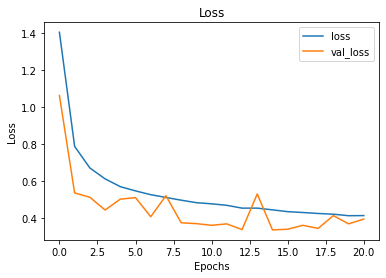

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

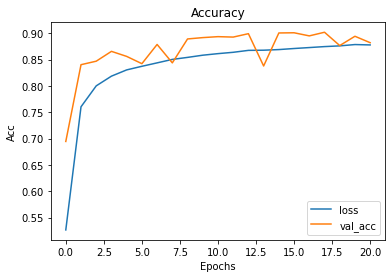

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['loss','val_acc'], loc='lower right')
plt.title("Accuracy")

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [32]:
from tensorflow.keras.models import load_model
cnnmodel = load_model('checkpoints_best_only\\bestonly.h5')
cnnmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 32)          128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 32)         

In [33]:
num_test_images = X_train_avg.shape[0]
print(X_train_avg.shape)
predimg=X_train_avg[1,:,:,:]
print(predimg.shape)
predimg = predimg[np.newaxis,...]
print(predimg.shape)
prediction = cnnmodel.predict(predimg)
print(prediction)

(73257, 32, 32, 1)
(32, 32, 1)
(1, 32, 32, 1)
[[3.4819411e-06 7.5843051e-04 2.4716872e-05 7.5845041e-05 6.9711086e-06
  4.3658434e-07 5.0412677e-06 2.9292363e-05 9.9857819e-01 5.1760196e-04]]


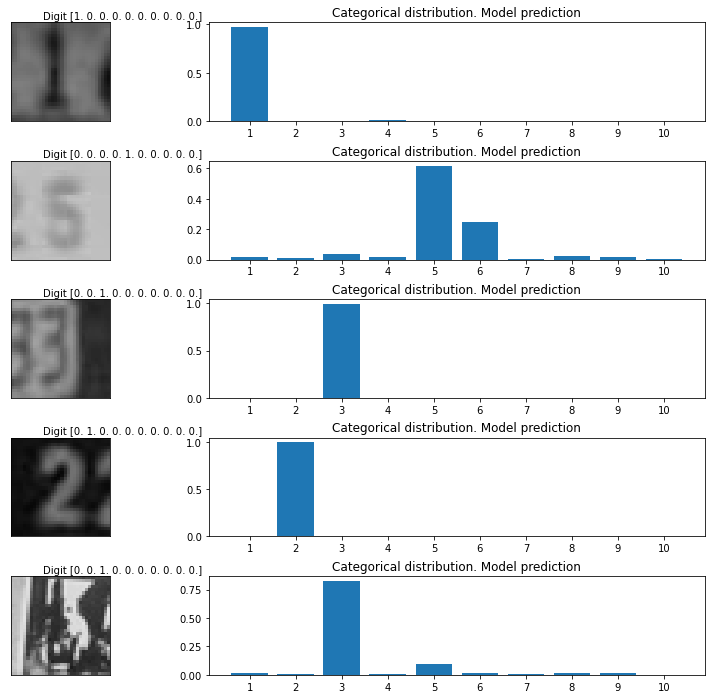

In [34]:
random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_train_avg[random_inx,...]
random_test_labels = y_train[random_inx]
fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)
predictions = cnnmodel.predict(random_test_images)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    #axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].imshow(np.squeeze(image),cmap='gray',vmin=0,vmax=255,label=y_train[indx])
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

In [35]:
seqmodel = load_model('seqmodel\\seqmodel.h5')

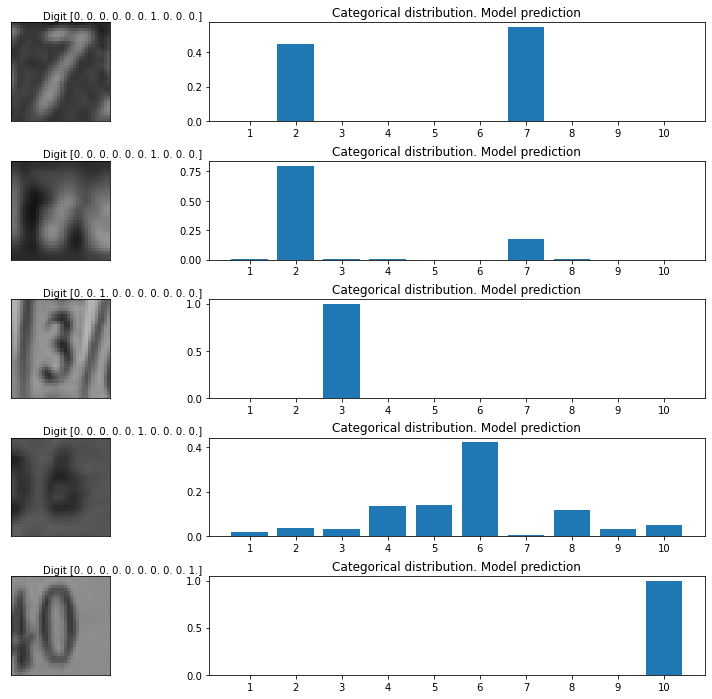

In [36]:
random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_train_avg[random_inx,...]
random_test_labels = y_train[random_inx]
fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)
predictions = seqmodel.predict(random_test_images)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    #axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].imshow(np.squeeze(image),cmap='gray',vmin=0,vmax=255,label=y_train[indx])
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()